# Satellite Drop Test Simulations 

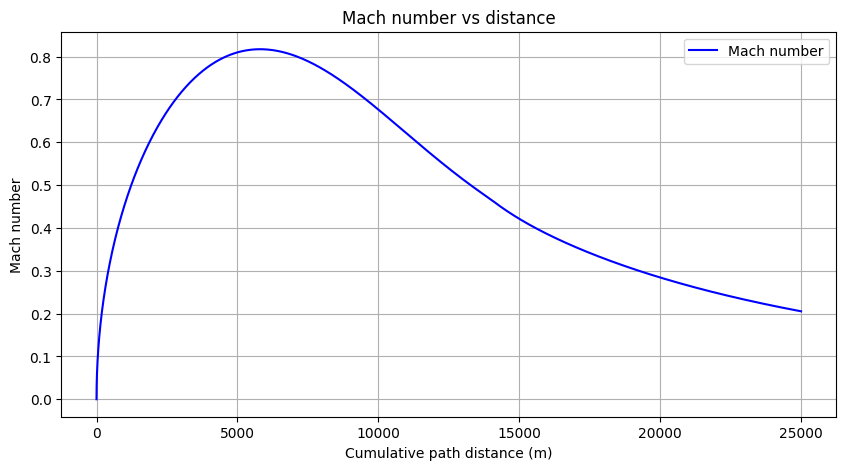

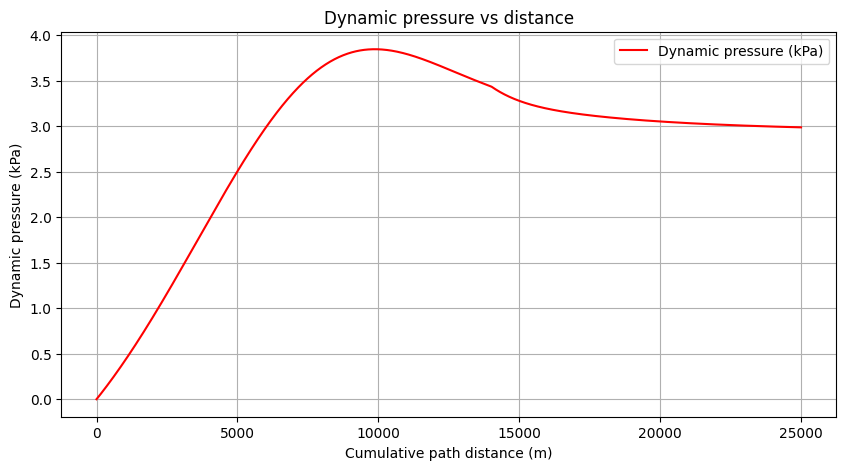

In [11]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Atmosphere (ISA up to 25 km) ---
def isa_T_P_rho(h):
    R = 287.05   # J/kg·K
    g0 = 9.80665 # m/s²
    P0 = 101325  # Pa
    T0 = 288.15  # K
    L  = -0.0065 # K/m

    if h < 0:
        h = 0.0
    if h <= 11000.0:
        T = T0 + L*h
        P = P0 * (T/T0) ** (-g0/(L*R))
    else:
        T = 216.65
        P11 = P0 * ((T/T0) ** (-g0/(L*R)))
        P = P11 * math.exp(-g0*(h-11000.0)/(R*T))
    rho = P / (R * T)
    return T, P, rho

def speed_of_sound(T):
    gamma = 1.4
    R = 287.05
    return math.sqrt(gamma * R * T)

def g_at_alt(h):
    Re = 6371000.0
    g0 = 9.80665
    return g0 * (Re / (Re + h))**2

# --- Simulation ---
def simulate_descent(Cd=0.6, m=25.0, A=0.6, h0=25000.0, dt=0.1):
    h, v, t, s = h0, 0.0, 0.0, 0.0
    ss, machs, qs = [s], [0.0], [0.0]

    while h > 0:
        T, P, rho = isa_T_P_rho(h)
        a = speed_of_sound(T)
        g = g_at_alt(h)

        Fd = 0.5 * rho * Cd * A * v * abs(v)
        dv = (m*g - Fd) / m * dt
        v += dv
        dh = v * dt
        h -= dh
        if h < 0:
            h = 0
        s += abs(v*dt)

        # Dynamic pressure
        q = 0.5 * rho * v**2

        ss.append(s)
        machs.append(abs(v)/a)
        qs.append(q)

    return np.array(ss), np.array(machs), np.array(qs)

# --- Run ---
s, mach, q = simulate_descent(Cd=1.2, m=250.0, A=0.7, h0=25000.0, dt=0.1)

# --- Plot Mach vs distance ---
plt.figure(figsize=(10,5))
plt.plot(s, mach, label="Mach number", color="blue")
plt.xlabel("Cumulative path distance (m)")
plt.ylabel("Mach number")
plt.title("Mach number vs distance")
plt.grid(True)
plt.legend()
plt.show()

# --- Plot q vs distance ---
plt.figure(figsize=(10,5))
plt.plot(s, q/1000, label="Dynamic pressure (kPa)", color="red")
plt.xlabel("Cumulative path distance (m)")
plt.ylabel("Dynamic pressure (kPa)")
plt.title("Dynamic pressure vs distance")
plt.grid(True)
plt.legend()
plt.show()

Peak dynamic pressure (q_max) = 652.2 Pa at distance = 4667.6 m, altitude = 20332.4 m
First time Mach < 0.8 at distance = 0.0 m, altitude = 25000.0 m (Mach=0.000)
Recommended drogue deployment at distance = 4680.1 m, altitude = 20319.9 m (Mach=0.423, q=652.2 Pa)


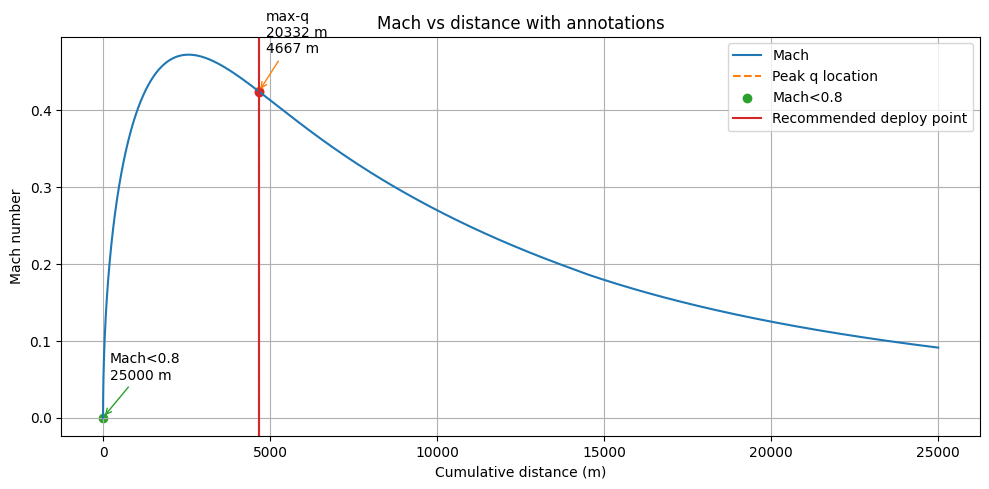

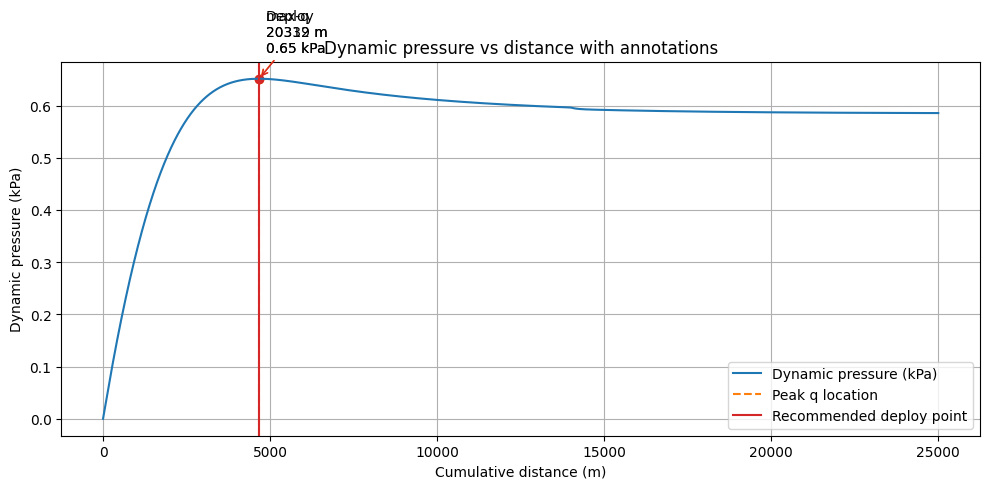

In [33]:
import math
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Atmosphere (ISA up to 25 km) ---
def isa_T_P_rho(h):
    R = 287.05; g0 = 9.80665; P0 = 101325; T0 = 288.15; L = -0.0065
    if h < 0: h = 0.0
    if h <= 11000.0:
        T = T0 + L*h
        P = P0 * (T/T0) ** (-g0/(L*R))
    else:
        T = 216.65
        P11 = P0 * ((T/T0) ** (-g0/(L*R)))
        P = P11 * math.exp(-g0*(h-11000.0)/(R*T))
    rho = P / (R * T)
    return T, P, rho

def speed_of_sound(T):
    gamma = 1.4; R = 287.05
    return math.sqrt(gamma * R * T)

def g_at_alt(h):
    Re = 6371000.0; g0 = 9.80665
    return g0 * (Re / (Re + h))**2

# --- Simulation: returns arrays for time, altitude, distance, velocity, mach, q ---
def simulate_descent(Cd=1.2, m=250.0, A=0.7, h0=25000.0, dt=0.1, max_steps=500000):
    h = h0; v = 0.0; t = 0.0; s = 0.0
    hs, vs, ts, ss, machs, qs = [h], [v], [t], [s], [0.0], [0.0]
    step = 0
    while h > 0 and step < max_steps:
        T, P, rho = isa_T_P_rho(h)
        a = speed_of_sound(T)
        g = g_at_alt(h)
        Fd = 0.5 * rho * Cd * A * v * abs(v)
        dv = (m*g - Fd) / m * dt
        v += dv
        dh = v * dt
        h -= dh
        if h < 0:
            h = 0.0
        s += abs(v * dt)
        t += dt
        q = 0.5 * rho * v**2
        hs.append(h); vs.append(v); ts.append(t); ss.append(s); machs.append(abs(v)/a); qs.append(q)
        step += 1
    return (np.array(ts), np.array(hs), np.array(ss), np.array(vs), np.array(machs), np.array(qs))

# --- Parameters (tweak as needed) ---
Cd = 0.6
m  = 25.0
A  = 0.7
h0 = 25000.0
dt = 0.1

# run sim
t, h, s, v, mach, q = simulate_descent(Cd=Cd, m=m, A=A, h0=h0, dt=dt)

# find peak q
idx_maxq = np.argmax(q)
s_maxq = s[idx_maxq]
h_maxq = h[idx_maxq]
q_max = q[idx_maxq]

# mach threshold and first crossing below threshold after max-q
mach_threshold = 0.8     # set to 0.8 (recommended); consider 0.5 for extra margin
# find first index where mach < threshold (searching from start)
idx_mach_first = np.where(mach < mach_threshold)[0]
idx_mach_below = idx_mach_first[0] if idx_mach_first.size>0 else None
s_mach_below = s[idx_mach_below] if idx_mach_below is not None else None
h_mach_below = h[idx_mach_below] if idx_mach_below is not None else None

# recommended deployment: the first point AFTER peak q where mach < threshold
idx_after_maxq = np.where(s > s_maxq)[0]
if idx_after_maxq.size == 0:
    # already on ground or no points after max-q -> fallback
    idx_deploy = max(idx_maxq, idx_mach_below if idx_mach_below is not None else idx_maxq)
else:
    # search indices after max-q for mach < threshold
    cand_idxs = idx_after_maxq[np.where(mach[idx_after_maxq] < mach_threshold)[0]]
    if cand_idxs.size > 0:
        idx_deploy = cand_idxs[0]
    else:
        # if not found after max-q, fall back to first mach below anywhere (or immediately after max-q)
        idx_deploy = idx_mach_below if idx_mach_below is not None else idx_maxq

s_deploy = s[idx_deploy]
h_deploy = h[idx_deploy]
mach_deploy = mach[idx_deploy]
q_deploy = q[idx_deploy]

# Print the key numbers
print(f"Peak dynamic pressure (q_max) = {q_max:.1f} Pa at distance = {s_maxq:.1f} m, altitude = {h_maxq:.1f} m")
if idx_mach_below is not None:
    print(f"First time Mach < {mach_threshold} at distance = {s_mach_below:.1f} m, altitude = {h_mach_below:.1f} m (Mach={mach[idx_mach_below]:.3f})")
else:
    print(f"Mach never drops below {mach_threshold} in simulation before ground.")
print(f"Recommended drogue deployment at distance = {s_deploy:.1f} m, altitude = {h_deploy:.1f} m (Mach={mach_deploy:.3f}, q={q_deploy:.1f} Pa)")

# --- Plot Mach vs distance with annotations ---
plt.figure(figsize=(10,5))
plt.plot(s, mach, label="Mach")
plt.axvline(s_maxq, color='tab:orange', linestyle='--', label="Peak q location")
plt.scatter([s_maxq], [mach[idx_maxq]], color='tab:orange')
plt.annotate(f"max-q\n{int(h_maxq)} m\n{int(s_maxq)} m", xy=(s_maxq, mach[idx_maxq]), xytext=(s_maxq+200, mach[idx_maxq]+0.05),
             arrowprops=dict(arrowstyle="->", color='tab:orange'))
if idx_mach_below is not None:
    plt.scatter([s_mach_below], [mach[idx_mach_below]], color='tab:green', label=f"Mach<{mach_threshold}")
    plt.annotate(f"Mach<{mach_threshold}\n{int(h_mach_below)} m", xy=(s_mach_below, mach[idx_mach_below]), xytext=(s_mach_below+200, mach[idx_mach_below]+0.05),
                 arrowprops=dict(arrowstyle="->", color='tab:green'))
plt.axvline(s_deploy, color='tab:red', linestyle='-', linewidth=1.5, label="Recommended deploy point")
plt.scatter([s_deploy], [mach[idx_deploy]], color='tab:red')
plt.xlabel("Cumulative distance (m)")
plt.ylabel("Mach number")
plt.title("Mach vs distance with annotations")
plt.grid(True)
plt.legend()
plt.tight_layout()

# --- Plot q vs distance with annotations ---
plt.figure(figsize=(10,5))
plt.plot(s, q/1000.0, label="Dynamic pressure (kPa)")
plt.axvline(s_maxq, color='tab:orange', linestyle='--', label="Peak q location")
plt.scatter([s_maxq], [q_max/1000.0], color='tab:orange')
plt.annotate(f"max-q\n{int(h_maxq)} m\n{q_max/1000.0:.2f} kPa", xy=(s_maxq, q_max/1000.0), xytext=(s_maxq+200, q_max/1000.0+0.05),
             arrowprops=dict(arrowstyle="->", color='tab:orange'))
plt.axvline(s_deploy, color='tab:red', linestyle='-', linewidth=1.5, label="Recommended deploy point")
plt.scatter([s_deploy], [q_deploy/1000.0], color='tab:red')
plt.annotate(f"Deploy\n{int(h_deploy)} m\n{q_deploy/1000.0:.2f} kPa", xy=(s_deploy, q_deploy/1000.0), xytext=(s_deploy+200, q_deploy/1000.0+0.05),
             arrowprops=dict(arrowstyle="->", color='tab:red'))
plt.xlabel("Cumulative distance (m)")
plt.ylabel("Dynamic pressure (kPa)")
plt.title("Dynamic pressure vs distance with annotations")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Deployment at s = 12005.1 m, altitude = 12994.9 m, v = 67.4 m/s, Mach = 0.228


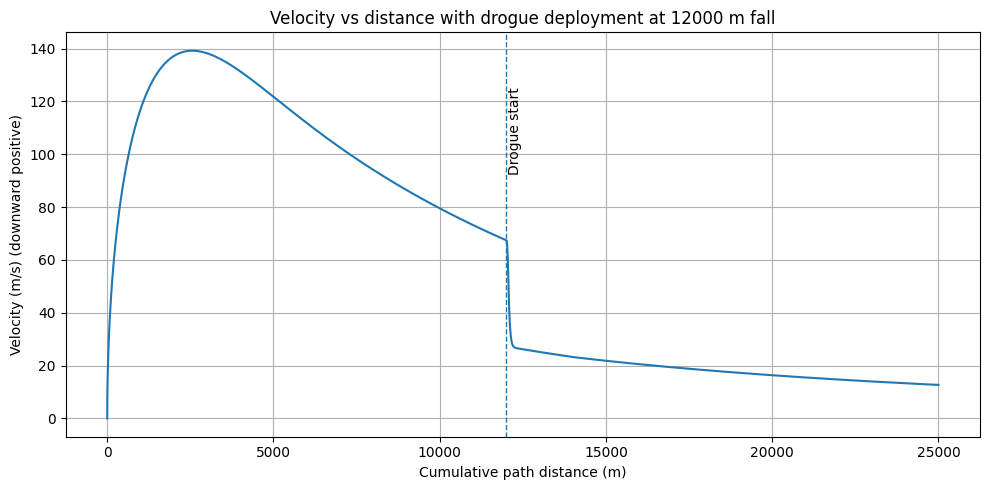

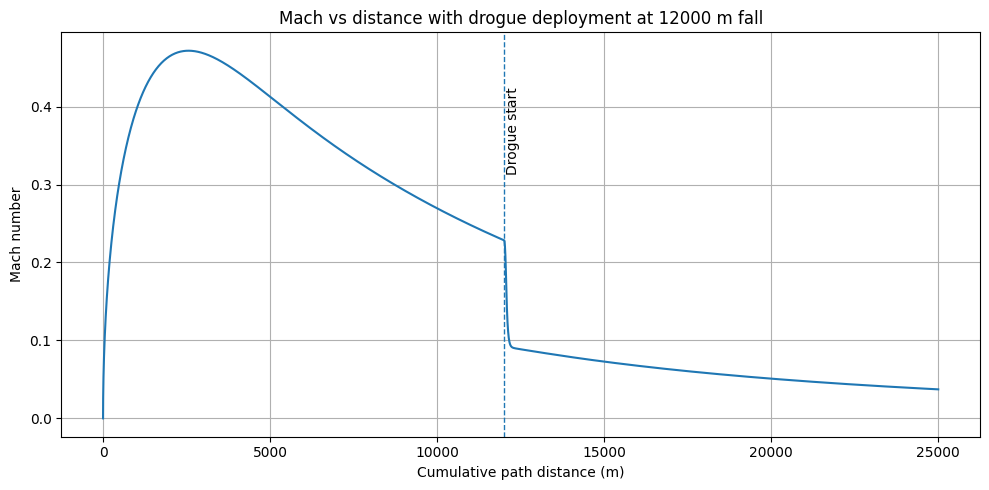

In [36]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Atmosphere (ISA up to 25 km) ---
def isa_T_P_rho(h):
    R = 287.05   # J/kg·K
    g0 = 9.80665 # m/s²
    P0 = 101325  # Pa
    T0 = 288.15  # K
    L  = -0.0065 # K/m (troposphere lapse rate)
    if h < 0:
        h = 0.0
    if h <= 11000.0:
        T = T0 + L*h
        P = P0 * (T/T0) ** (-g0/(L*R))
    else:
        T = 216.65
        P11 = P0 * ((T/T0) ** (-g0/(L*R)))
        P = P11 * math.exp(-g0*(h-11000.0)/(R*T))
    rho = P / (R * T)
    return T, P, rho

def speed_of_sound(T):
    gamma = 1.4
    R = 287.05
    return math.sqrt(gamma * R * T)

def g_at_alt(h):
    Re = 6371000.0  # Earth radius (m)
    g0 = 9.80665
    return g0 * (Re / (Re + h))**2

# --- Two-phase descent simulation ---
def simulate_with_drogue(
    Cd_capsule=0.6, A_capsule=0.7, m=25.0,
    Cd_drogue= 1.5, A_drogue=1.0,    # drogue: larger area, higher effective Cd
    deploy_fall_distance=12000.0,    # distance traveled from release when drogue begins to open (m)
    h0=25000.0, dt=0.1, open_time=3.0
):
    # state
    h = h0
    v = 0.0   # downward positive
    t = 0.0
    s = 0.0   # cumulative path distance (m)
    phase = "pre"  # "pre" or "deploying" or "post"

    # arrays
    hs, vs, ts, ss, machs, qs = [h], [v], [t], [s], [0.0], [0.0]
    Cd = Cd_capsule
    A = A_capsule

    # simulate
    deploying = False
    deploy_started = False
    deploy_start_time = None
    step = 0
    max_steps = 1000000

    while h > 0 and step < max_steps:
        T, P, rho = isa_T_P_rho(h)
        a = speed_of_sound(T)
        g = g_at_alt(h)

        # Check if we should start deployment
        if (not deploy_started) and (s >= deploy_fall_distance):
            deploy_started = True
            deploying = True
            deploy_start_time = t
            phase = "deploying"
            # store pre-deploy Cd/A
            Cd_pre, A_pre = Cd, A

        # If deploying, ramp Cd and A from capsule to drogue values over open_time seconds
        if deploying:
            frac = min(1.0, (t - deploy_start_time) / open_time)
            Cd = Cd_capsule + frac * (Cd_drogue - Cd_capsule)
            A  = A_capsule   + frac * (A_drogue - A_capsule)
            if frac >= 1.0:
                deploying = False
                phase = "post"

        # Drag (0.5 rho Cd A v^2), v positive downward
        Fd = 0.5 * rho * Cd * A * v * abs(v)

        # dv/dt = g - Fd/m
        dv = (g - Fd / m) * dt
        v += dv
        dh = v * dt
        h -= dh
        if h < 0:
            h = 0.0

        s += abs(v * dt)
        t += dt

        q = 0.5 * rho * v**2

        hs.append(h); vs.append(v); ts.append(t); ss.append(s); machs.append(abs(v)/a); qs.append(q)
        step += 1

    data = {
        "t": np.array(ts),
        "h": np.array(hs),
        "s": np.array(ss),
        "v": np.array(vs),
        "mach": np.array(machs),
        "q": np.array(qs)
    }
    return data

# --- Default parameters (you can change these) ---
params = {
    "Cd_capsule": 0.6,
    "A_capsule": 0.7,
    "m": 25.0,
    "Cd_drogue": 2.5,
    "A_drogue": 1.0,
    "deploy_fall_distance": 12000.0,  # deployment after 12 km fall (i.e., altitude = 25km - 12km = 13km)
    "h0": 25000.0,
    "dt": 0.1,
    "open_time": 1
}

data = simulate_with_drogue(**params)

# --- Find index corresponding to deploy point (first s >= deploy distance) ---
deploy_idx = np.where(data["s"] >= params["deploy_fall_distance"])[0]
deploy_idx = int(deploy_idx[0]) if deploy_idx.size>0 else 0
deploy_s = data["s"][deploy_idx]
deploy_h = data["h"][deploy_idx]
deploy_v = data["v"][deploy_idx]
deploy_mach = data["mach"][deploy_idx]

print("Deployment at s = {:.1f} m, altitude = {:.1f} m, v = {:.1f} m/s, Mach = {:.3f}".format(
    deploy_s, deploy_h, deploy_v, deploy_mach))

# --- Plot: velocity vs distance ---
plt.figure(figsize=(10,5))
plt.plot(data["s"], data["v"])
plt.axvline(deploy_s, linestyle='--', linewidth=1.0)
plt.text(deploy_s + 50, max(data["v"])*0.9, "Drogue start", rotation=90, va='top')
plt.xlabel("Cumulative path distance (m)")
plt.ylabel("Velocity (m/s) (downward positive)")
plt.title("Velocity vs distance with drogue deployment at {:.0f} m fall".format(params["deploy_fall_distance"]))
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot: Mach vs distance ---
plt.figure(figsize=(10,5))
plt.plot(data["s"], data["mach"])
plt.axvline(deploy_s, linestyle='--', linewidth=1.0)
plt.text(deploy_s + 50, max(data["mach"])*0.9, "Drogue start", rotation=90, va='top')
plt.xlabel("Cumulative path distance (m)")
plt.ylabel("Mach number")
plt.title("Mach vs distance with drogue deployment at {:.0f} m fall".format(params["deploy_fall_distance"]))
plt.grid(True)
plt.tight_layout()
plt.show()

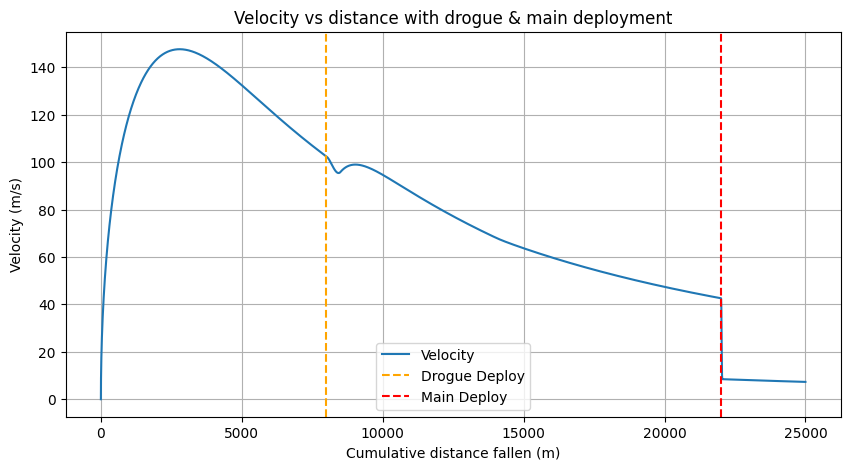

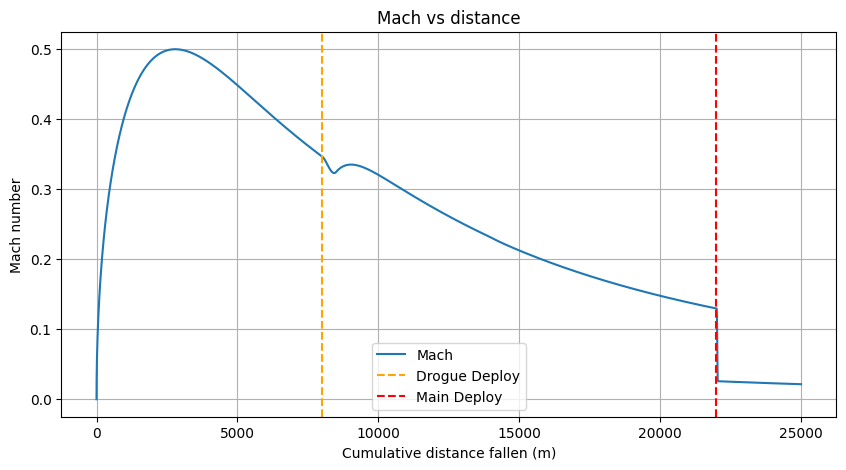

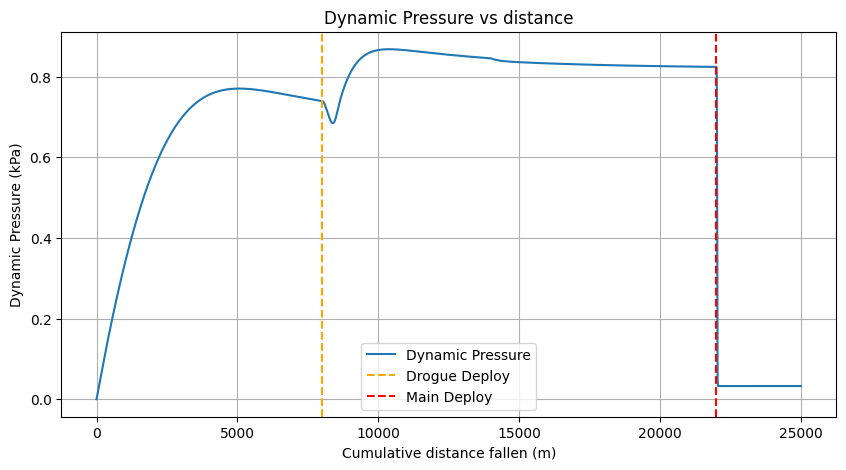

In [32]:
import math
import numpy as np
import matplotlib.pyplot as plt

# --- Atmosphere (ISA up to 25 km) ---
def isa_T_P_rho(h):
    R = 287.05   # J/kg·K
    g0 = 9.80665 # m/s²
    P0 = 101325  # Pa
    T0 = 288.15  # K
    L  = -0.0065 # K/m (troposphere lapse rate)
    if h < 0:
        h = 0.0
    if h <= 11000.0:
        T = T0 + L*h
        P = P0 * (T/T0) ** (-g0/(L*R))
    else:
        T = 216.65
        P11 = P0 * ((T/T0) ** (-g0/(L*R)))
        P = P11 * math.exp(-g0*(h-11000.0)/(R*T))
    rho = P / (R * T)
    return T, P, rho

def speed_of_sound(T):
    gamma = 1.4
    R = 287.05
    return math.sqrt(gamma * R * T)

def g_at_alt(h):
    Re = 6371000.0  # Earth radius (m)
    g0 = 9.80665
    return g0 * (Re / (Re + h))**2

# --- Multi-phase descent simulation ---
def simulate_with_parachutes(
    Cd_capsule=1.2, A_capsule=0.7, m=250.0,
    Cd_drogue=2.5, A_drogue=10.0, deploy_fall_distance_drogue=12000.0, open_time_drogue=3.0,
    Cd_main=2.2, A_main=50.0, deploy_fall_distance_main=16000.0, open_time_main=5.0,
    h0=25000.0, dt=0.1
):
    # state
    h = h0
    v = 0.0   # downward positive
    t = 0.0
    s = 0.0   # cumulative path distance (m)

    # deployment states
    drogue_started, drogue_deploying = False, False
    drogue_start_time = None

    main_started, main_deploying = False, False
    main_start_time = None

    # arrays
    hs, vs, ts, ss, machs, qs = [h], [v], [t], [s], [0.0], [0.0]
    Cd = Cd_capsule
    A = A_capsule

    step = 0
    max_steps = 1000000
    while h > 0 and step < max_steps:
        T, P, rho = isa_T_P_rho(h)
        a = speed_of_sound(T)
        g = g_at_alt(h)

        # Drogue deploy trigger
        if (not drogue_started) and (s >= deploy_fall_distance_drogue):
            drogue_started, drogue_deploying = True, True
            drogue_start_time = t
            Cd_pre, A_pre = Cd, A

        # Drogue deploying ramp
        if drogue_deploying:
            frac = min(1.0, (t - drogue_start_time) / open_time_drogue)
            Cd = Cd_capsule + frac * (Cd_drogue - Cd_capsule)
            A  = A_capsule + frac * (A_drogue - A_capsule)
            if frac >= 1.0:
                drogue_deploying = False

        # Main deploy trigger
        if (not main_started) and (s >= deploy_fall_distance_main):
            main_started, main_deploying = True, True
            main_start_time = t
            Cd_pre, A_pre = Cd, A

        # Main deploying ramp
        if main_deploying:
            frac = min(1.0, (t - main_start_time) / open_time_main)
            Cd = Cd + frac * (Cd_main - Cd)   # ramp from current to main
            A  = A + frac * (A_main - A)
            if frac >= 1.0:
                main_deploying = False

        # Drag force
        Fd = 0.5 * rho * Cd * A * v * abs(v)

        # dv/dt = g - Fd/m
        dv = (g - Fd / m) * dt
        v += dv
        dh = v * dt
        h -= dh
        if h < 0:
            h = 0.0

        s += abs(v * dt)
        t += dt

        q = 0.5 * rho * v**2

        hs.append(h); vs.append(v); ts.append(t); ss.append(s); machs.append(abs(v)/a); qs.append(q)
        step += 1

    return {
        "t": np.array(ts),
        "h": np.array(hs),
        "s": np.array(ss),
        "v": np.array(vs),
        "mach": np.array(machs),
        "q": np.array(qs)
    }

# --- Run simulation with drogue at 12 km fall, main at 16 km fall ---
params = {
    "Cd_capsule": 0.6,
    "A_capsule": 0.6,
    "m": 25.0,
    "Cd_drogue": 1.5,
    "A_drogue": 0.2,
    "deploy_fall_distance_drogue": 8000.0,
    "open_time_drogue": 5.0,
    "Cd_main": 1.5,
    "A_main": 5.0,
    "deploy_fall_distance_main": 22000.0,
    "open_time_main": 5.0,
    "h0": 25000.0,
    "dt": 0.1
}

data = simulate_with_parachutes(**params)

# --- Plot results ---
plt.figure(figsize=(10,5))
plt.plot(data["s"], data["v"], label="Velocity")
plt.axvline(params["deploy_fall_distance_drogue"], color="orange", linestyle="--", label="Drogue Deploy")
plt.axvline(params["deploy_fall_distance_main"], color="red", linestyle="--", label="Main Deploy")
plt.xlabel("Cumulative distance fallen (m)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity vs distance with drogue & main deployment")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(data["s"], data["mach"], label="Mach")
plt.axvline(params["deploy_fall_distance_drogue"], color="orange", linestyle="--", label="Drogue Deploy")
plt.axvline(params["deploy_fall_distance_main"], color="red", linestyle="--", label="Main Deploy")
plt.xlabel("Cumulative distance fallen (m)")
plt.ylabel("Mach number")
plt.title("Mach vs distance")
plt.legend(); plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(data["s"], data["q"]/1000, label="Dynamic Pressure")
plt.axvline(params["deploy_fall_distance_drogue"], color="orange", linestyle="--", label="Drogue Deploy")
plt.axvline(params["deploy_fall_distance_main"], color="red", linestyle="--", label="Main Deploy")
plt.xlabel("Cumulative distance fallen (m)")
plt.ylabel("Dynamic Pressure (kPa)")
plt.title("Dynamic Pressure vs distance")
plt.legend(); plt.grid(True)
plt.show()